In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import itertools

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
def k_fold_cv(model, X_train, y_train):
    """executes sklearn's k-fold cross-validation on a given sklearn model
    
    :param model: sklearn classification model 
    :X_train: pandas.DataFrame or numpy.array, matrix containing 
    :y_train: pandas.Series, containing labels for the training data
    :return accuracy, misclassifications_avg: Average accuracy and misclassification rate over all folds
    """
    kf = KFold(n_splits=10, random_state=42, shuffle=True)

    y_train = np.array(y_train)
    misclassifications = []

    for train_index, test_index in kf.split(X_train):

        train_X, test_X = X_train[train_index], X_train[test_index]
        train_y, test_y = y_train[train_index], y_train[test_index]

        clf = model.fit(train_X, train_y)
        print(clf.score(test_X, test_y))
        
        prediction = clf.predict(test_X)
        misclassifications.append(np.mean(prediction != test_y))
    
    misclassifications_avg = sum(misclassifications)/len(misclassifications)
    accuracy = 1-(sum(misclassifications)/len(misclassifications))
    
    return accuracy, misclassifications_avg

# Investigating Feature Importance

### Data Preparation

In [66]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [67]:
X = train_df.drop(columns=['Lead'])
y = train_df['Lead']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [69]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Feature importance using Logistic Regression

In [70]:
parameters = {'C': [0.01, 0.1, 1, 10, 100, 200, 300, 400]}

clf = LogisticRegression()

gs = GridSearchCV(clf, parameters)

gs.fit(X_train, y_train)
print(gs.best_params_)

{'C': 200}


In [71]:
accuracy, misclassifications = k_fold_cv(LogisticRegression(**gs.best_params_), X_train, y_train)

print('accuracy: ', accuracy)
print('misclassifications: ', misclassifications)

0.9178082191780822
0.863013698630137
0.8493150684931506
0.863013698630137
0.8493150684931506
0.9452054794520548
0.8082191780821918
0.9027777777777778
0.8472222222222222
0.8055555555555556
accuracy:  0.8651445966514459
misclassifications:  0.13485540334855403


In [72]:
clf = LogisticRegression(**gs.best_params_).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8910256410256411

### Influence of each feature by investigating coefficients of Logistic Regression

In [73]:
for i in range(len(X.columns)):
    print(X.columns[i], '\n', clf.coef_[0][i])
    print(' ')

Number words female 
 14.749103821871048
 
Total words 
 -3.4663473901655593
 
Number of words lead 
 -13.997592849390387
 
Difference in words lead and co-lead 
 20.31550713910402
 
Number of male actors 
 7.8582216463135595
 
Year 
 0.16068573735498548
 
Number of female actors 
 -10.509542877238937
 
Number words male 
 -2.5685697014232787
 
Gross 
 1.9144201015062485
 
Mean Age Male 
 -1.237365557520277
 
Mean Age Female 
 0.6751330710989943
 
Age Lead 
 3.8712993231040995
 
Age Co-Lead 
 -3.6026399725316693
 


By printing the coefficients for each feature, we can investigate how strongly one feature effects the logistic regression models' prediction. 
Small valued coefficents of a variable mean that it's influence is rather low (low feature importance).
The higher the coefficient, the higher is the influence of the corresponding feature (high feature importance). 

Features with low influence: 
- Year
- Number words male 
- Gross
- Mean Age Male 
- Mean Age Female 

## Feature Importance using Random Forest

In [74]:
parameters = {'n_estimators': [100, 200, 500, 750],
             'max_depth': [6, 8, 12, 14]}

clf = RandomForestClassifier()

gs = GridSearchCV(clf, parameters)

gs.fit(X_train, y_train)
print(gs.best_params_)

{'max_depth': 12, 'n_estimators': 200}


In [75]:
accuracy, misclassifications = k_fold_cv(RandomForestClassifier(**gs.best_params_), X_train, y_train)

print('accuracy: ', accuracy)
print('misclassifications: ', misclassifications)

0.9041095890410958
0.726027397260274
0.821917808219178
0.8767123287671232
0.7808219178082192
0.863013698630137
0.7671232876712328
0.8611111111111112
0.8472222222222222
0.8055555555555556
accuracy:  0.8253614916286149
misclassifications:  0.1746385083713851


In [76]:
clf = RandomForestClassifier(**gs.best_params_).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8269230769230769

In [77]:
scores = {}

for i in range(len(X.columns)):
    scores[X.columns[i]] = clf.feature_importances_[i]

dict(sorted(scores.items(), key=lambda item: item[1]))

{'Gross': 0.05162458660831491,
 'Year': 0.05342161171076853,
 'Mean Age Male': 0.057137374820115445,
 'Total words': 0.0572978653744315,
 'Number of words lead': 0.05937477178233097,
 'Number words male': 0.06349240625737651,
 'Mean Age Female': 0.06803488025445663,
 'Number of male actors': 0.07432745851245814,
 'Age Co-Lead': 0.08051771128614486,
 'Difference in words lead and co-lead': 0.09041183549542955,
 'Number of female actors': 0.09627151518468963,
 'Age Lead': 0.10736488496639139,
 'Number words female': 0.14072309774709194}

The feature_importances_ property of the sklearn's Random Forest provides insight of the importance of each feature. 
It is calculated using Gini importance, the higher the value, the more important the feature.

Features with low influence:
- Year
- Gross
- Number of words lead
- Total words
- Mean Age Male
- Number words male

Investigating the feature importance using Logistic Regression and Random Forest, we can assume that the following features
have a low influence on the prediction:
- Year
- Number words male
- Gross
- Mean Age Male
- Mean Age Female
- Number of words lead
- Total words

To determine which of these features we should drop to receive the best result for a given model, we write the function
'best_feature_subset':

In [ ]:
def best_feature_subset(model, parameter_grid, df):
    """Calculates k-fold cross-validation accuracy for a given model and different feature inputs.
    
    Each combination of the following features is excluded from the training set. For each of these combinations, a separate
    model is trained and evaluated using k-fold cross-validation. The dropped features and resulting k-fold cross 
    validation accuracies are stored in a dictionary. 
    
    The features that got excluded from the dataset are:
    - Year
    - Number words male
    - Gross
    - Mean Age Male
    - Mean Age Female
    - Number of words lead
    - Total words
    These features showed lowest feature importance (investigation done using Random Forest and Logistic Regression)
    
    
    :param model: sklearn classification model 
    :param parameter_grid: dictionary, containing possible parameter combinations for gridsearch
    :param df: pandas.DataFrame, containing training data including labels
    :return sorted_accuracies: dictionary, containing cross-validation accuracies for each feature combination. 
                                Sorted in increasing order.
    """
    features = ['Year', 'Number words male', 'Gross', 'Mean Age Male', 'Mean Age Female', 'Number of words lead', 'Total words']

    accuracies = {}

    for i in range(len(features)):
        ls_of_subfeatures = list(itertools.combinations(features, i))

        for combi in ls_of_subfeatures:
            features_to_drop = list(combi) + ['Lead']
            print(str(features_to_drop))

            X = train_df.drop(columns=features_to_drop)
            y = train_df['Lead']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

            # MinMaxScaler
            scaler = preprocessing.MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # gridsearch
            gs = GridSearchCV(model(), parameter_grid)

            gs.fit(X_train, y_train)

            accuracy, _ = k_fold_cv(model(**gs.best_params_), X_train, y_train)
            feature_string = ', '.join(combi)
            accuracies[feature_string] = accuracy
    sorted_accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1])) 
    return sorted_accuracies

# Feature Selection using "best_feature_subset"

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## KNN

In [ ]:
parameters = {'n_neighbors': [3,5,7,9,11,13,15]}

best_feature_subset(KNeighborsClassifier, parameters, train_df)

Optimal features to drop: 
- Year
- Number words male
- Mean Age Male
- Total words

## Logistic Regression

In [ ]:
parameters = {'C': [0.01, 0.1, 1, 10, 100, 200, 300, 400]}

best_feature_subset(LogisticRegression, parameters, train_df)

Optimal features to drop: 
- Year 
- Gross
- Mean Age Male
- Total words

## QDA

In [ ]:
parameters = {}
best_feature_subset(QuadraticDiscriminantAnalysis, parameters, train_df)

Optimal features to drop:
- Year
- Total words

## LDA

In [ ]:
parameters = {}
best_feature_subset(LinearDiscriminantAnalysis, parameters, train_df)

Optimal features to drop:
- Year
- Gross
- Mean Age Male
- Total words

## Random Forest

In [ ]:
parameters = {'n_estimators': [100, 200, 500],
             'max_depth': [6, 8, 12]}

best_feature_subset(RandomForestClassifier, parameters, train_df)

Optimal features to drop:
- Gross
- Mean Age Male
- Mean Age Female
- Total words

## SVM

In [ ]:
parameters = {'C': [1, 10, 100, 150],
              'kernel': ['poly', 'rbf'],
             'gamma': ['scale', 'auto']}

best_feature_subset(SVC, parameters, train_df)

Optimal features to drop:
- Year
- Gross
- Mean Age Male
- Mean Age Female
- Total words

# Training and Evaluating the models with optimal features

## KNN

In [354]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [355]:
# Features to drop: 
# 'Year, Number words male, Mean Age Male, Total words'

X = train_df.drop(columns=['Lead', 'Year', 'Number words male', 'Mean Age Male', 'Total words'])
y = train_df['Lead']

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [357]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [358]:
# Gridsearch
parameters = {'n_neighbors': [3,5,7,9,11,13,15],
             'weights': ['uniform', 'distance'], 
             'metric': ['minkowski', 'manhattan', 'chebyshev']}

clf = KNeighborsClassifier()

gs = GridSearchCV(clf, parameters)

gs.fit(X_train, y_train)
print(gs.best_params_)

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [359]:
# Cross Validation

accuracy, misclassifications = k_fold_cv(KNeighborsClassifier(**gs.best_params_), X_train, y_train)

print('')
print('accuracy: ', accuracy)
print('misclassifications: ', misclassifications)

0.8767123287671232
0.7671232876712328
0.8082191780821918
0.8356164383561644
0.7534246575342466
0.821917808219178
0.7945205479452054
0.8333333333333334
0.7916666666666666
0.7638888888888888

accuracy:  0.8046423135464231
misclassifications:  0.19535768645357685


In [360]:
# Score on test set

clf = KNeighborsClassifier(**gs.best_params_).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8012820512820513

In [362]:
# Confusion Matrix

prediction = clf.predict(X_test)

# plt.rcParams.update({'font.size': 17})

# cfm = plot_confusion_matrix(clf, X_test, y_test, cmap='Blues') 
# plt.savefig('confusion_matrix_knn.jpg', bbox_inches="tight")
# plt.show()

In [328]:
# Evaluation Scores 

print('Precision: ', precision_score(y_test, prediction, pos_label='Female'))
print('Recall: ', recall_score(y_test, prediction, pos_label='Female'))
print('F1 Score: ', f1_score(y_test, prediction, pos_label='Female'))

Precision:  0.7631578947368421
Recall:  0.35365853658536583
F1 Score:  0.4833333333333333


## Logistic Regression 

In [277]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [278]:
# Features to drop: 
# 'Year, Gross, Mean Age Male, Total words'

X = train_df.drop(columns=['Lead', 'Year', 'Gross', 'Mean Age Male', 'Total words'])
y = train_df['Lead']

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [280]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [281]:
# Gridsearch
parameters = {'C': [0.01, 0.1, 1, 10, 100, 200, 300, 400]}

clf = LogisticRegression()

gs = GridSearchCV(clf, parameters)

gs.fit(X_train, y_train)
print(gs.best_params_)

{'C': 300}


In [282]:
# Cross Validation

accuracy, misclassifications = k_fold_cv(LogisticRegression(**gs.best_params_), X_train, y_train)

print('')
print('accuracy: ', accuracy)
print('misclassifications: ', misclassifications)

0.9452054794520548
0.863013698630137
0.821917808219178
0.863013698630137
0.8493150684931506
0.9452054794520548
0.8082191780821918
0.9166666666666666
0.875
0.7916666666666666

accuracy:  0.8679223744292237
misclassifications:  0.13207762557077624


In [283]:
# Score on test set

clf = LogisticRegression(**gs.best_params_).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8974358974358975

In [363]:
# Confusion Matrix

prediction = clf.predict(X_test)

# plt.rcParams.update({'font.size': 17})
# plot_confusion_matrix(clf, X_test, y_test, cmap='Blues') 
# plt.savefig('confusion_matrix_logisticregression.jpg', bbox_inches="tight")
# plt.show()

In [285]:
# Evaluation Scores 

print('Precision: ', precision_score(y_test, prediction, pos_label='Female'))
print('Recall: ', recall_score(y_test, prediction, pos_label='Female'))
print('F1 Score: ', f1_score(y_test, prediction, pos_label='Female'))

Precision:  0.9166666666666666
Recall:  0.6707317073170732
F1 Score:  0.7746478873239437


## LDA

In [286]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [287]:
# Features to drop: 
# 'Year, Gross, Mean Age Male, Total words'

X = train_df.drop(columns=['Lead', 'Year', 'Gross', 'Mean Age Male', 'Total words'])
y = train_df['Lead']

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [289]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [290]:
# Cross Validation

accuracy, misclassifications = k_fold_cv(LinearDiscriminantAnalysis(), X_train, y_train)

print('')
print('accuracy: ', accuracy)
print('misclassifications: ', misclassifications)

0.958904109589041
0.8493150684931506
0.821917808219178
0.8904109589041096
0.863013698630137
0.9041095890410958
0.7808219178082192
0.9166666666666666
0.8472222222222222
0.8194444444444444

accuracy:  0.8651826484018266
misclassifications:  0.13481735159817348


In [291]:
# Score on test set

clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
clf.score(X_test, y_test)

0.8717948717948718

In [364]:
# Confusion Matrix

prediction = clf.predict(X_test)

# plt.rcParams.update({'font.size': 17})
# plot_confusion_matrix(clf, X_test, y_test, cmap='Blues') 
# plt.savefig('confusion_matrix_lda.jpg', bbox_inches="tight")
# plt.show()

In [293]:
# Evaluation Scores 

print('Precision: ', precision_score(y_test, prediction, pos_label='Female'))
print('Recall: ', recall_score(y_test, prediction, pos_label='Female'))
print('F1 Score: ', f1_score(y_test, prediction, pos_label='Female'))

Precision:  0.85
Recall:  0.6219512195121951
F1 Score:  0.7183098591549296


## QDA

In [294]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [295]:
# Features to drop: 
# 'Year, Total words'

X = train_df.drop(columns=['Lead', 'Year', 'Total words'])
y = train_df['Lead']

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [297]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [298]:
# Cross Validation

accuracy, misclassifications = k_fold_cv(QuadraticDiscriminantAnalysis(), X_train, y_train)

print('')
print('accuracy: ', accuracy)
print('misclassifications: ', misclassifications)

0.9452054794520548
0.8904109589041096
0.8356164383561644
0.8904109589041096
0.9178082191780822
0.9315068493150684
0.8904109589041096
0.8611111111111112
0.875
0.8888888888888888

accuracy:  0.8926369863013699
misclassifications:  0.10736301369863013


In [299]:
# Score on test set

clf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
clf.score(X_test, y_test)

0.8974358974358975

In [365]:
# Confusion Matrix

prediction = clf.predict(X_test)

# plt.rcParams.update({'font.size': 17})
# plot_confusion_matrix(clf, X_test, y_test, cmap='Blues') 
# plt.savefig('confusion_matrix_qda.jpg', bbox_inches="tight")
# plt.show()

In [301]:
# Evaluation Scores 

print('Precision: ', precision_score(y_test, prediction, pos_label='Female'))
print('Recall: ', recall_score(y_test, prediction, pos_label='Female'))
print('F1 Score: ', f1_score(y_test, prediction, pos_label='Female'))

Precision:  0.8571428571428571
Recall:  0.7317073170731707
F1 Score:  0.7894736842105263


## Random Forest

In [302]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [303]:
# Features to drop: 
# Gross, Mean Age Male, Mean Age Female, Total words'

X = train_df.drop(columns=['Lead', 'Gross', 'Mean Age Male', 'Mean Age Female', 'Total words'])
y = train_df['Lead']

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [305]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [306]:
# Gridsearch

parameters = {'n_estimators': [100, 200, 500, 750],
             'max_depth': [6, 8, 12, 14]}

clf = RandomForestClassifier()

gs = GridSearchCV(clf, parameters)

gs.fit(X_train, y_train)
print(gs.best_params_)

{'max_depth': 14, 'n_estimators': 200}


In [307]:
# Cross Validation

accuracy, misclassifications = k_fold_cv(RandomForestClassifier(**gs.best_params_), X_train, y_train)

print('')
print('accuracy: ', accuracy)
print('misclassifications: ', misclassifications)

0.9315068493150684
0.7945205479452054
0.863013698630137
0.863013698630137
0.7671232876712328
0.8904109589041096
0.7808219178082192
0.8611111111111112
0.8055555555555556
0.8194444444444444

accuracy:  0.8376522070015221
misclassifications:  0.16234779299847793


In [308]:
# Score on test set

clf = RandomForestClassifier(**gs.best_params_).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8301282051282052

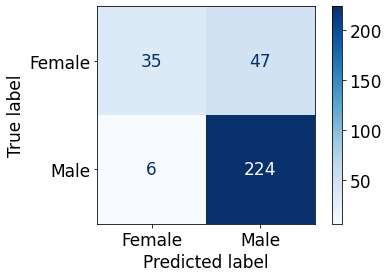

In [309]:
# Confusion Matrix

prediction = clf.predict(X_test)

# plt.rcParams.update({'font.size': 17})
# plot_confusion_matrix(clf, X_test, y_test, cmap='Blues') 
# plt.savefig('confusion_matrix_rf.jpg', bbox_inches="tight")
# plt.show()

In [310]:
# Evaluation Scores 

print('Precision: ', precision_score(y_test, prediction, pos_label='Female'))
print('Recall: ', recall_score(y_test, prediction, pos_label='Female'))
print('F1 Score: ', f1_score(y_test, prediction, pos_label='Female'))

Precision:  0.8536585365853658
Recall:  0.4268292682926829
F1 Score:  0.5691056910569106


## Support Vector Machine

In [329]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [330]:
# Features to drop: 
# 'Year, Gross, Mean Age Male, Mean Age Female, Total words'

X = train_df.drop(columns=['Lead', 'Year', 'Gross', 'Mean Age Male', 'Mean Age Female', 'Total words'])
y = train_df['Lead']

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [314]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [315]:
# Gridsearch
parameters = {'C': [0.1, 1, 10, 100, 150, 200],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma': ['scale', 'auto']}
clf = SVC()

gs = GridSearchCV(clf, parameters)

gs.fit(X_train, y_train)
print(gs.best_params_)

{'C': 100, 'gamma': 'scale', 'kernel': 'poly'}


In [316]:
# Cross Validation

accuracy, misclassifications = k_fold_cv(SVC(**gs.best_params_), X_train, y_train)

print('')
print('accuracy: ', accuracy)
print('misclassifications: ', misclassifications)

0.9863013698630136
0.8904109589041096
0.9041095890410958
0.9315068493150684
0.9178082191780822
0.8904109589041096
0.8082191780821918
0.8888888888888888
0.9583333333333334
0.875

accuracy:  0.9050989345509893
misclassifications:  0.09490106544901065


In [317]:
# Score on test set

clf = SVC(**gs.best_params_).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9006410256410257

In [366]:
# Confusion Matrix

prediction = clf.predict(X_test)

# plt.rcParams.update({'font.size': 17})
# plot_confusion_matrix(clf, X_test, y_test, cmap='Blues') 
# plt.savefig('confusion_matrix_svm.jpg', bbox_inches="tight")
# plt.show()

In [319]:
# Evaluation Scores 

print('Precision: ', precision_score(y_test, prediction, pos_label='Female'))
print('Recall: ', recall_score(y_test, prediction, pos_label='Female'))
print('F1 Score: ', f1_score(y_test, prediction, pos_label='Female'))

Precision:  0.8591549295774648
Recall:  0.7439024390243902
F1 Score:  0.7973856209150327


# Final Prediction on Test Set using SVM

### Train model on whole training data

In [3]:
train_df = pd.read_csv('train.csv')

In [4]:
X = train_df.drop(columns=['Lead', 'Year', 'Gross', 'Mean Age Male', 'Mean Age Female', 'Total words'])
y = train_df['Lead']

In [5]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)

### Prepare Testset

In [6]:
# load test set
test_df = pd.read_csv('test.csv')

# select features
Test_X = test_df.drop(columns=['Year', 'Gross', 'Mean Age Male', 'Mean Age Female', 'Total words'])

In [7]:
# scale data
Test_X = scaler.transform(Test_X)

### Predictions

In [31]:
# fit final SVC model
clf = SVC(C=100, gamma='scale', kernel='poly').fit(X, y)

# label prediction
y_pred = clf.predict(Test_X)

### Save results

In [33]:
y_pred = np.where(y_pred == 'Male', 0, 1)
y_pred = y_pred.flatten()

In [37]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [70]:
import csv

y_pred = list(y_pred)

with open('predictions.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(y_pred) 